##### Copyright 2019 The TensorFlow Authors.

Code Source : https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

## Setup

### Install pip packages

Start by installing the TensorFlow Text and Model Garden pip packages.

*  `tf-models-official` is the TensorFlow Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` GitHub repo. To include the latest changes, you may install `tf-models-nightly`, which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [ ]:
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install protobuf==3.20.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q -U tensorflow-text

In [ ]:
!pip install -U tf-models-official


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [ ]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'


In [ ]:
import tensorflow_models as tfm
import tensorflow_datasets as tfds
import tensorflow_hub as hub



tfds.disable_progress_bar()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Resources

The following directory contains the BERT model's configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Load and preprocess the dataset

This example uses the GLUE (General Language Understanding Evaluation) MRPC (Microsoft Research Paraphrase Corpus) [dataset from TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up such that it can be directly fed into the BERT model. The following section handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The GLUE MRPC (Dolan and Brockett, 2005) dataset is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent. It has the following attributes:

*   Number of labels: 2
*   Size of training dataset: 3668
*   Size of evaluation dataset: 408
*   Maximum sequence length of training and evaluation dataset: 128

Begin by loading the MRPC dataset from TFDS:

In [ ]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [ ]:
glue

{Split('train'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('test'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

The `info` object describes the dataset and its features:

In [ ]:
info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

The two classes are:

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [ ]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### Preprocess the data

The keys `"sentence1"` and `"sentence2"` in the GLUE MRPC dataset contain two input sentences for each example.

Because the BERT model from the Model Garden doesn't take raw text as input, two things need to happen first:

1. The text needs to be _tokenized_ (split into word pieces) and converted to _indices_.
2. Then, the _indices_ need to be packed into the format that the model expects.

#### The BERT tokenizer

To fine tune a pre-trained language model from the Model Garden, such as BERT, you need to make sure that you're using exactly the same tokenization, vocabulary, and index mapping as used during training.

The following code rebuilds the tokenizer that was used by the base model using the Model Garden's `tfm.nlp.layers.FastWordpieceBertTokenizer` layer:

In [ ]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

Let's tokenize a test sentence:

In [ ]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

Learn more about the tokenization process in the [Subword tokenization](https://www.tensorflow.org/text/guide/subwords_tokenizer) and [Tokenizing with TensorFlow Text](https://www.tensorflow.org/text/guide/tokenizers) guides.

#### Pack the inputs

TensorFlow Model Garden's BERT model doesn't just take the tokenized strings as input. It also expects these to be packed into a particular format. `tfm.nlp.layers.BertPackInputs` layer can handle the conversion from _a list of tokenized sentences_ to the input format expected by the Model Garden's BERT model.

`tfm.nlp.layers.BertPackInputs` packs the two input sentences (per example in the MRCP dataset) concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token.

Therefore, the `tfm.nlp.layers.BertPackInputs` layer's constructor takes the `tokenizer`'s special tokens as an argument. It also needs to know the indices of the tokenizer's special tokens.

In [ ]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [ ]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

The `packer` takes a list of tokenized sentences as input. For example:

In [ ]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [ ]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

Then, it returns a dictionary containing three outputs:

- `input_word_ids`: The tokenized sentences packed together.
- `input_mask`: The mask indicating which locations are valid in the other outputs.
- `input_type_ids`: Indicating which sentence each token belongs to.

In [ ]:
packed = packer([tok1, tok2])

for key, tensor in packed.items():
  print(f"{key:15s}: {tensor[:, :12]}")

input_word_ids : [[  101  7592 23435 12314   102  9119 23435 12314   102     0     0     0]]
input_mask     : [[1 1 1 1 1 1 1 1 1 0 0 0]]
input_type_ids : [[0 0 0 0 0 1 1 1 1 0 0 0]]


#### Put it all together

Combine these two parts into a `keras.layers.Layer` that can be attached to your model:

In [ ]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

But for now just apply it to the dataset using `Dataset.map`, since the dataset you loaded from TFDS is a `tf.data.Dataset` object:

In [ ]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [ ]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

Here is an example batch from the processed dataset:

In [ ]:
example_inputs, example_labels = next(iter(glue_train))

In [ ]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [ ]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


The `input_word_ids` contain the token IDs:

In [ ]:
plt.pcolormesh(example_inputs['input_word_ids'])

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
plt.pcolormesh(example_inputs['input_mask'])

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of.

In [ ]:
plt.pcolormesh(example_inputs['input_type_ids'])

Apply the same preprocessing to the validation and test subsets of the GLUE MRPC dataset:

In [ ]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

## Build, train and export the model

Now that you have formatted the data as expected, you can start working on building and training the model.

### Build the model


The first step is to download the configuration file—`config_dict`—for the pre-trained BERT model:


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [ ]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

The configuration file defines the core BERT model from the Model Garden, which is a Keras model that predicts the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

In [ ]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [ ]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[-1.4705746 ,  0.18176548],
       [-0.97919524, -0.3183003 ],
       [-1.1605666 , -0.82243514],
       [-0.7916697 ,  0.09132914],
       [-0.40316364, -0.33956933],
       [-0.9300875 , -0.08896375],
       [-0.59141654,  0.12409794],
       [-0.44436097, -0.02852029],
       [-1.2384297 , -1.1641701 ],
       [-1.3244503 , -0.8292564 ]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

If you inspect the encoder, notice the stack of `Transformer` layers connected to those same three inputs:

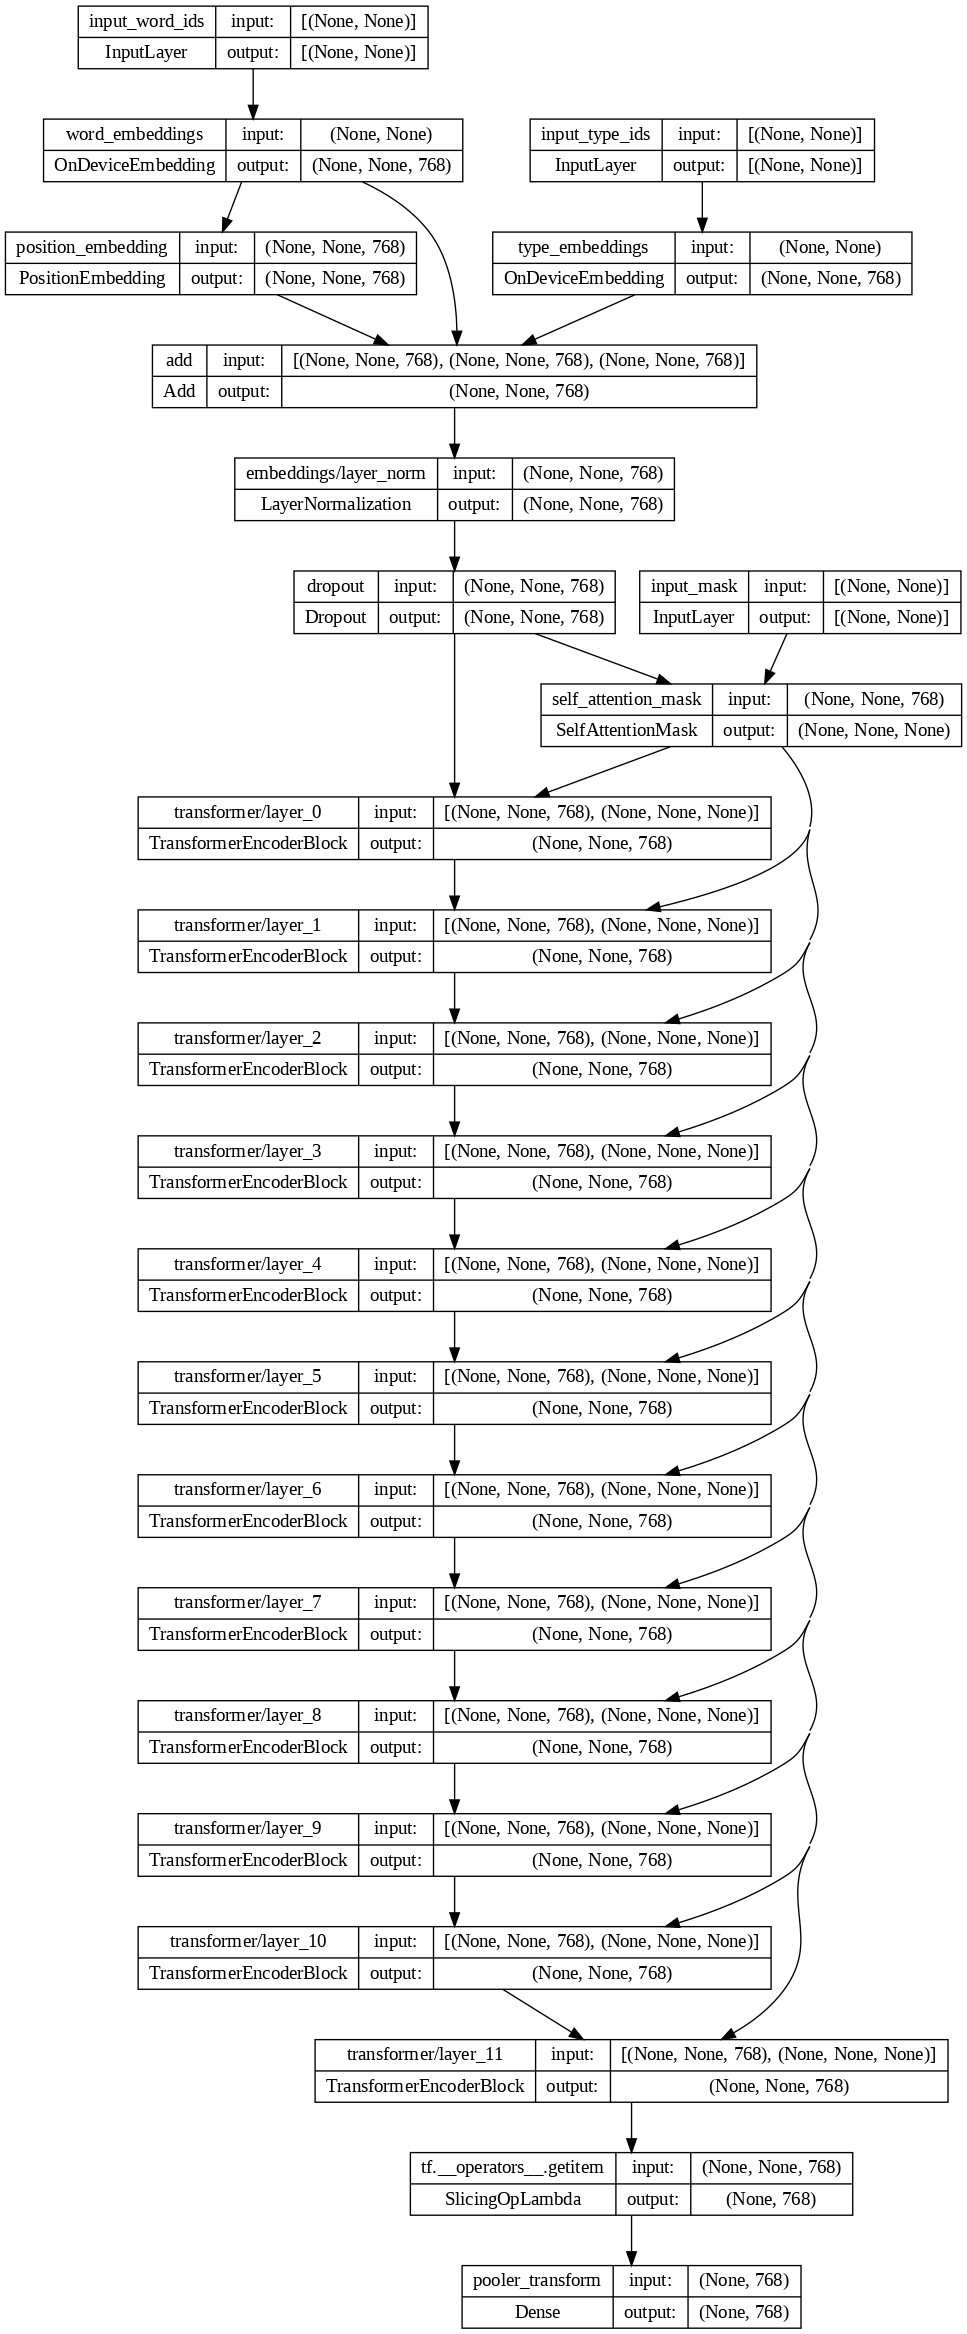

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=98)

### Restore the encoder weights

When built, the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). Go to the [TF Hub appendix](#hub_bert) for details.

### Set up the optimizer

BERT typically uses the Adam optimizer with weight decay—[AdamW](https://arxiv.org/abs/1711.05101) (`tf.keras.optimizers.experimental.AdamW`).
It also employs a learning rate schedule that first warms up from 0 and then decays to 0:

In [ ]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

Linear decay from `initial_learning_rate` to zero over `num_train_steps`.

In [ ]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

Warmup to that value over `warmup_steps`:

In [ ]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

The overall schedule looks like this:

In [ ]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Text(47.097222222222214, 0.5, 'Learning rate')

Use `tf.keras.optimizers.experimental.AdamW` to instantiate the optimizer with that schedule:

In [ ]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

### Train the model

Set the metric as accuracy and the loss as sparse categorical cross-entropy. Then, compile and train the BERT classifier:

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [ ]:
bert_classifier.evaluate(glue_validation)

13/13 [==============================] - 7s 271ms/step - loss: 1.6073 - accuracy: 0.3162


[1.60733163356781, 0.31617647409439087]

In [ ]:
bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

Epoch 1/5
115/115 [==============================] - 153s 896ms/step - loss: 0.8241 - accuracy: 0.5891 - val_loss: 0.5260 - val_accuracy: 0.7328
Epoch 2/5
115/115 [==============================] - 99s 858ms/step - loss: 0.4856 - accuracy: 0.7644 - val_loss: 0.5094 - val_accuracy: 0.8137
Epoch 3/5
115/115 [==============================] - 99s 857ms/step - loss: 0.3255 - accuracy: 0.8637 - val_loss: 0.4791 - val_accuracy: 0.7966
Epoch 4/5
115/115 [==============================] - 99s 860ms/step - loss: 0.1896 - accuracy: 0.9215 - val_loss: 0.5884 - val_accuracy: 0.7990
Epoch 5/5
115/115 [==============================] - 100s 873ms/step - loss: 0.1147 - accuracy: 0.9613 - val_loss: 0.5769 - val_accuracy: 0.8162


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [ ]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [ ]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [ ]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'equivalent', b'not_equivalent'], dtype=object)>

### Export the model

Often the goal of training a model is to _use_ it for something outside of the Python process that created it. You can do this by exporting the model using `tf.saved_model`. (Learn more in the [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model) guide and the [Save and load a model using a distribution strategy](https://www.tensorflow.org/tutorials/distribute/save_and_load) tutorial.)

First, build a wrapper class to export the model. This wrapper does two things:

- First it packages `bert_inputs_processor` and `bert_classifier` together into a single `tf.Module`, so you can export all the functionalities.
- Second it defines a `tf.function` that implements the end-to-end execution of the model.

Setting the `input_signature` argument of `tf.function` lets you define a fixed signature for the `tf.function`. This can be less surprising than the default automatic retracing behavior.

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, input_processor, classifier):
    self.input_processor = input_processor
    self.classifier = classifier

  @tf.function(input_signature=[{
      'sentence1': tf.TensorSpec(shape=[None], dtype=tf.string),
      'sentence2': tf.TensorSpec(shape=[None], dtype=tf.string)}])
  def __call__(self, inputs):
    packed = self.input_processor(inputs)
    logits =  self.classifier(packed, training=False)
    result_cls_ids = tf.argmax(logits)
    return {
        'logits': logits,
        'class_id': result_cls_ids,
        'class': tf.gather(
            tf.constant(info.features['label'].names),
            result_cls_ids)
    }

Create an instance of this export-model and save it:

In [ ]:
export_model = ExportModel(bert_inputs_processor, bert_classifier)

In [ ]:
import tempfile
export_dir=tempfile.mkdtemp(suffix='_saved_model')
tf.saved_model.save(export_model, export_dir=export_dir,
                    signatures={'serving_default': export_model.__call__})

Reload the model and compare the results to the original:

In [ ]:
original_logits = export_model(my_examples)['logits']

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_logits = reloaded(my_examples)['logits']

In [ ]:
# The results are identical:
print(original_logits.numpy())
print()
print(reloaded_logits.numpy())

In [ ]:
print(np.mean(abs(original_logits - reloaded_logits)))

Congratulations! You've used `tensorflow_models` to build a BERT-classifier, train it, and export for later use.

## Optional: BERT on TF Hub

<a id="hub_bert"></a>


You can get the BERT model off the shelf from [TF Hub](https://tfhub.dev/). There are [many versions available along with their input preprocessors](https://tfhub.dev/google/collections/bert/1).

This example uses [a small version of BERT from TF Hub](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2) that was pre-trained using the English Wikipedia and BooksCorpus datasets, similar to the [original implementation](https://arxiv.org/abs/1908.08962) (Turc et al., 2019).

Start by importing TF Hub:

In [ ]:
import tensorflow_hub as hub

Select the input preprocessor and the model from TF Hub and wrap them as `hub.KerasLayer` layers:

In [ ]:
# Always make sure you use the right preprocessor.
hub_preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# This is a really small BERT.
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

Test run the preprocessor on a batch of data:

In [ ]:
hub_inputs = hub_preprocessor(['Hello TensorFlow!'])
{key: value[0, :10].numpy() for key, value in hub_inputs.items()} 

In [ ]:
result = hub_encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

At this point it would be simple to add a classification head yourself.

The Model Garden `tfm.nlp.models.BertClassifier` class can also build a classifier onto the TF Hub encoder:

In [ ]:
hub_classifier = tfm.nlp.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

The one downside to loading this model from TF Hub is that the structure of internal Keras layers is not restored. This makes it more difficult to inspect or modify the model.

The BERT encoder model—`hub_classifier`—is now a single layer.

For concrete examples of this approach, refer to [Solve Glue tasks using BERT](https://www.tensorflow.org/text/tutorials/bert_glue).

## Optional: Optimizer `config`s

The `tensorflow_models` package defines serializable `config` classes that describe how to build the live objects. Earlier in this tutorial, you built the optimizer manually.

The configuration below describes an (almost) identical optimizer built by the `optimizer_factory.OptimizerFactory`:

In [ ]:
optimization_config = tfm.optimization.OptimizationConfig(
    optimizer=tfm.optimization.OptimizerConfig(
        type = "adam"),
    learning_rate = tfm.optimization.LrConfig(
        type='polynomial',
        polynomial=tfm.optimization.PolynomialLrConfig(
            initial_learning_rate=2e-5,
            end_learning_rate=0.0,
            decay_steps=num_train_steps)),
    warmup = tfm.optimization.WarmupConfig(
        type='linear',
        linear=tfm.optimization.LinearWarmupConfig(warmup_steps=warmup_steps)
    ))


fac = tfm.optimization.optimizer_factory.OptimizerFactory(optimization_config)
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)

In [ ]:
x = tf.linspace(0, num_train_steps, 1001).numpy()
y = [lr(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

The advantage to using `config` objects is that they don't contain any complicated TensorFlow objects, and can be easily serialized to JSON, and rebuilt. Here's the JSON for the above `tfm.optimization.OptimizationConfig`:

In [ ]:
optimization_config = optimization_config.as_dict()
optimization_config

The `tfm.optimization.optimizer_factory.OptimizerFactory` can just as easily build the optimizer from the JSON dictionary:

In [ ]:
fac = tfm.optimization.optimizer_factory.OptimizerFactory(
    tfm.optimization.OptimizationConfig(optimization_config))
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)